In [1]:
import numpy as np
import pandas as pd
%matplotlib inline 
import matplotlib.pyplot as plt
import os
import numpy as np
import copy

In [2]:
from OpSimSummary import summarize_opsim as oss
import sncosmo

/usr/local/manual/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [3]:
from metrics import PerSNMetric
from efficiencyTable import EfficiencyTable

In [4]:
from lsst.sims.photUtils import BandpassDict

In [5]:
from lsst.sims.utils.coordinateTransformations import haversine

In [6]:
# Catsim bandpasses
lsst_bp = BandpassDict.loadTotalBandpassesFromFiles()

In [7]:
# sncosmo Bandpasses required for fitting
throughputsdir = os.getenv('THROUGHPUTS_DIR')

from astropy.units import Unit
bandPassList = ['u', 'g', 'r', 'i', 'z', 'y']
banddir = os.path.join(os.getenv('THROUGHPUTS_DIR'), 'baseline')

for band in bandPassList:

    # setup sncosmo bandpasses
    bandfname = banddir + "/total_" + band + '.dat'


    # register the LSST bands to the SNCosmo registry
    # Not needed for LSST, but useful to compare independent codes
    # Usually the next two lines can be merged,
    # but there is an astropy bug currently which affects only OSX.
    numpyband = np.loadtxt(bandfname)
    print band
    sncosmoband = sncosmo.Bandpass(wave=numpyband[:, 0],
                                   trans=numpyband[:, 1],
                                   wave_unit=Unit('nm'),
                                   name=band)
    sncosmo.registry.register(sncosmoband, force=True)

u
g
r
i
z
y


In [8]:
import psops as testps

In [9]:
lsstReq = testps.LSSTReq

In [10]:
x = testps.LSST_Obs(mjd_center=49540, lsstrequirements=lsstReq)

In [11]:
x.bumpFactors

u    1
g    1
r    1
i    1
z    1
y    1
dtype: float64

In [12]:
lc = x.obsValues()

In [13]:
lc.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night
0,49510.000000,g,0,0,25,1,49510
1,49536.666667,g,0,0,25,1,49536
2,49563.333333,g,0,0,25,1,49563
3,49510.000000,i,0,0,24,1,49510
4,49526.000000,i,0,0,24,1,49526


In [14]:
q = PerSNMetric(summarydf=lc, t0=49540, raCol='ra', decCol='dec', lsst_bp=lsst_bp, fieldID=None)

In [15]:
q.SN.SNstate

{'MWE(B-V)': 0.031526423990726471,
 'ModelSource': 'salt2-extended',
 '_dec': 0.0,
 '_ra': 0.0,
 'c': 0.0,
 'hostebv': 0.0,
 'hostr_v': 3.1000000000000001,
 'mwebv': 0.0,
 'mwr_v': 3.1000000000000001,
 't0': 49540.0,
 'x0': 1.0068661711630977e-05,
 'x1': 0.0,
 'z': 0.5}

In [16]:
q.df

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night,MJDay
0,49510.000000,g,0,0,25.0,1,49510,49510
1,49536.666667,g,0,0,25.0,1,49536,49536
2,49563.333333,g,0,0,25.0,1,49563,49563
3,49510.000000,i,0,0,24.0,1,49510,49510
4,49526.000000,i,0,0,24.0,1,49526,49526
5,49542.000000,i,0,0,24.0,1,49542,49542
6,49558.000000,i,0,0,24.0,1,49558,49558
7,49574.000000,i,0,0,24.0,1,49574,49574
8,49510.000000,r,0,0,24.7,1,49510,49510
9,49526.000000,r,0,0,24.7,1,49526,49526


In [17]:
q.lsst_bp['g']

<lsst.sims.photUtils.Bandpass.Bandpass instance at 0x114656e60>

In [18]:
qdf = q.df
qdf['band'] = qdf['filter'].apply(lambda x: x.lower())

In [19]:
qdf.head()

,expMJD,filter,ra,dec,fiveSigmaDepth,fieldID,night,MJDay,band
0,49510.000000,g,0,0,25,1,49510,49510,g
1,49536.666667,g,0,0,25,1,49536,49536,g
2,49563.333333,g,0,0,25,1,49563,49563,g
3,49510.000000,i,0,0,24,1,49510,49510,i
4,49526.000000,i,0,0,24,1,49526,49526,i


In [20]:
qdf['flux'] = qdf.apply(lambda row: q.SN.catsimBandFluxes(row['expMJD'], 
                      q.lsst_bp[row['band']]), axis=1)

In [21]:
q.lsst_bp['g'].wavelen

array([  300. ,   300.1,   300.2, ...,  1149.8,  1149.9,  1150. ])

In [22]:
q.summary['filter']

0     g
1     g
2     g
3     i
4     i
5     i
6     i
7     i
8     r
9     r
10    r
11    r
12    r
13    u
14    u
15    y
16    y
17    y
18    y
19    y
20    z
21    z
22    z
23    z
24    z
Name: filter, dtype: object

In [23]:
q.lightcurve

19


,time,band,flux,fluxerr,zp,zpsys,SNR,fiveSigmaDepth,night,DetectionEfficiency
10,49542.000000,r,7.989467e-10,2.820028e-11,0,ab,28.331164,24.7,49542,NaN
5,49542.000000,i,7.894048e-10,5.130814e-11,0,ab,15.385567,24.0,49542,NaN
9,49526.000000,r,4.112269e-10,2.714882e-11,0,ab,15.147133,24.7,49526,NaN
1,49536.666667,g,3.084444e-10,2.060987e-11,0,ab,14.965860,25.0,49536,NaN
11,49558.000000,r,3.687259e-10,2.703108e-11,0,ab,13.640813,24.7,49558,NaN
6,49558.000000,i,5.331382e-10,5.080129e-11,0,ab,10.494582,24.0,49558,NaN
22,49542.000000,z,8.468149e-10,9.628731e-11,0,ab,8.794668,23.3,49542,NaN
4,49526.000000,i,3.863358e-10,5.050864e-11,0,ab,7.648905,24.0,49526,NaN
23,49558.000000,z,5.253037e-10,9.579735e-11,0,ab,5.483489,23.3,49558,NaN
7,49574.000000,i,2.502934e-10,5.023593e-11,0,ab,4.982359,24.0,49574,NaN


19


metrics.py:104: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  lc['flux'] = lc['flux'] + lc['deviation'] * lc['fluxerr']


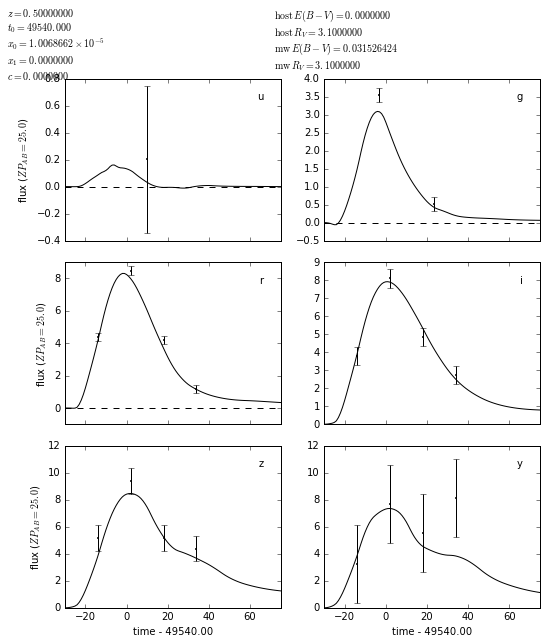

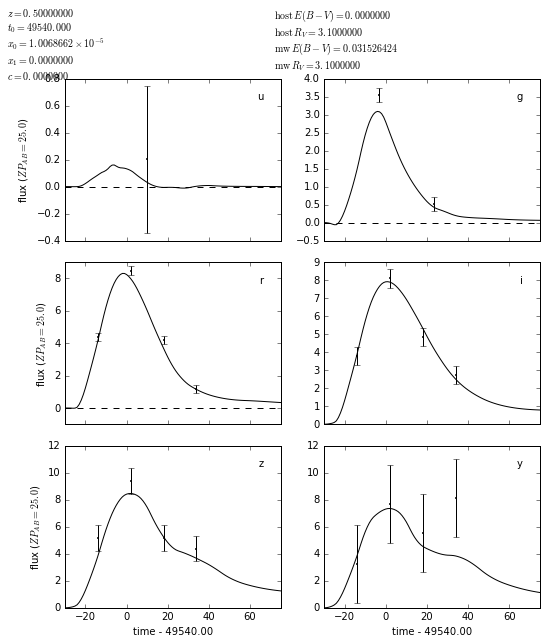

In [25]:
q.lcplot(scattered=True)

# Scratch

In [ ]:
opsimHDF = os.path.join(os.getenv('HOME'), 'data', 'LSST', 'OpSimData', 'storage.h5')
summarydf = pd.read_hdf(opsimHDF, 'table')



In [ ]:
summarydf.query('fieldID == 290')[['fieldRA', 'fieldDec']].head()

In [ ]:
posns = pd.read_csv('example_data/posns.txt', delim_whitespace=True)

In [ ]:
posns['ra_radians']= np.radians(posns.RAdeg)
posns['dec_radians']= np.radians(posns.Decdeg)

In [ ]:
posns.ix[0, 'ra_radians']

In [ ]:
radius = np.radians(1.75)

In [ ]:
def distance(ra1, dec1, ra2, dec2):
    """
    Obtain the angular distance in radians between two points with given
    ra, dec values in radians
    
    Parameters
    ----------
    ra1 : array like, mandatory
    dec1 :
    ra2 :
    dec2 :
    """
    cosDelta = np.cos(dec1)* np.cos(dec2) *np.cos(ra1 -ra2) + np.sin(dec1)*np.sin(dec2)
    return np.arccos(cosDelta)

In [ ]:
def _obsForSN(summarydf, ind):
    summarydf['observed'] = 0
    summarydf['distance'] = distance(summarydf['ditheredRA'], 
                                     summarydf['ditheredDec'],
                                     #ra, dec)
                                     posns.ix[ind, 'ra_radians'], 
                                     posns.ix[ind, 'dec_radians'])
    
    summarydf.ix[summarydf.distance < radius, 'observed'] = 1
    return summarydf.groupby('observed').get_group(1)

In [ ]:
qm_0 = PerSNMetric(t0=49484, summarydf=_obsForSN(summarydf, 0), lsst_bp=lsst_bp, raCol='ditheredRA', decCol='ditheredDec')

In [ ]:
qm_0.lsst_bp[qm_0.df['filter'].iloc[0]].wavelen

In [ ]:
dftest = qm_0.df.copy()

In [ ]:
dftest['filter'].apply(lambda x: x.lower())

In [ ]:
dftest['filter'] = dftest['filter'].apply(lambda x: x.lower())

In [ ]:
'Y' in dftest['filter']

In [ ]:
dftest.apply(lambda row: qm_0.SN.catsimBandFluxes(row['expMJD'], 
                                                  qm_0.lsst_bp[row['filter']]),axis=1)

In [ ]:
band in qm_0.df.columns

In [ ]:
qm_0.lcplot(nightlyCoadd=True)

In [ ]:
x = qm_0.SNCosmoLC()

In [ ]:
model = sncosmo

In [ ]:
qm_0.sncosmoModel

In [ ]:
print(qm_0.sncosmoModel)

In [ ]:
mcmc_out = sncosmo.mcmc_lc(x, model=qm_0.sncosmoModel, 
                vparam_names=['t0', 'x0', 'x1', 'c'], 
                bounds={'c':(-0.3, 0.3), 'x1':(-3.0, 3.0)}, 
                minsnr=0.)

In [ ]:
mcmc_out[0]['samples']

In [ ]:
mcmc_out[0].keys()

In [ ]:
import corner

In [ ]:
corner.corner(mcmc_out[0].samples, labels=mcmc_out[0]['vparam_names'])

In [ ]:
mcmc_out[0].covariance

In [ ]:
qm_0.fits[0]['vparam_names']

In [ ]:
fitres = qm_0.fits[0] 

In [ ]:
type(fitres)

In [ ]:
vparam_names = fitres.vparam_names

In [ ]:
for v in vparam_names:
    print fitres.param_names.index(v)

In [ ]:
res = fitres

In [ ]:
vparams = [res.parameters[res.param_names.index(v)] for v in res.vparam_names]

In [ ]:
np.take(res.covariance, [[0, 2], [0,2]])

In [ ]:
df = pd.DataFrame(res.covariance)

In [ ]:
df

In [ ]:
res.covariance[0:2, :2]

In [ ]:
res.covariance[np.ix_([0, 2, 3], [0, 2, 3])]

In [ ]:
res.errors.values()

In [ ]:
res.errors.keys() == res.vparam_names

In [ ]:
res.errors.values()[0]

In [ ]:
res.covariance[0,0] **0.5

In [ ]:
[res.covariance[i,i]**0.5 - res.errors.values()[i] for i in range(4) ]

In [ ]:
ind = [i in param_names.index(v) for v in vparam_names]

In [ ]:
type(fitres.parameters)

In [ ]:
vparams = [fitres.parameters[i] for i in fitres.param_names.index(vp) for vp in vparam_names]

In [ ]:
for vp in vparam_names:
    for i in 

In [ ]:
[fitres.parameters[i] for vp in vparam_names for i in fitres.param_names.index(vp)]

In [ ]:
vparams = [qm_0.fits[0]qm_0.fits[0].param_names.index('x0')]

In [ ]:
qm_0.fits[0].covariance

In [ ]:
qm_0.SN.SNstate

In [ ]:
from lsst.sims.catUtils.mixins import SNObject

In [ ]:
t = SNObject(ra=30., dec=60.)

In [ ]:
print(t.source.name)

In [ ]:
t.equivalentSNCosmoModel()

In [ ]:
qm_0.SN.equivalentSNCosmoModel()

In [ ]:
import collections

In [ ]:
print 'Regular dictionary:'
rd = {}
rd['a'] = 'A'
rd['b'] = 'B'
rd['c'] = 'C'
rd['d'] = 'D'
rd['e'] = 'E'

for k, v in rd.items():
    print k, v

In [ ]:
dir(rd)

In [ ]:
clear(d)

In [ ]:
print '\nOrderedDict:'
d = collections.OrderedDict()
d['a'] = 'A'
d['b'] = 'B'
d['c'] = 'C'
d['d'] = 'D'
d['e'] = 'E'

for k, v in d.items():
    print k, v
    

In [ ]:
dir(d)

In [ ]:
d.values()

In [ ]:
np.atleast_2d(1)

In [ ]:
np.atleast_1d([1, 2])

In [ ]:
import itertools

In [ ]:
l = np.arange(len(vparams))

In [ ]:
for val in itertools.product(l, repeat=0):
    print val

In [ ]:
for item in itertools.combinations_with_replacement(l, 2):
    print list(item)

In [ ]:
fig = plt.subplot

In [ ]:
for item in itertools.combinations_with_replacement(l, 2):
    print item

In [ ]:
res.covariance[np.ix_([1,2], [1,2])]

In [ ]:
import matplotlib.mlab as mlab

In [ ]:
delta = 0.025
x = np.arange(-3.0, 3.0, delta)
y = np.arange(-2.0, 2.0, delta)
X, Y = np.meshgrid(x, y)
Z1 = mlab.bivariate_normal(X, Y, 1.0, 1.0, 0.0, 0.0)
Z2 = mlab.bivariate_normal(X, Y, 1.5, 0.5, 1, 1)
# difference of Gaussians
Z = 10.0 * (Z2 - Z1)



In [ ]:
plt.figure()
CS = plt.contour(X, Y, Z)
plt.clabel(CS, inline=1, fontsize=10)

In [ ]:
plt.figure()
CS = plt.contour(X, Y, Z)
manual_locations = [(-1, -1.4), (-0.62, -0.7), (-2, 0.5), (1.7, 1.2), (2.0, 1.4), (2.4, 1.7)]
plt.clabel(CS, inline=1, fontsize=10, manual=manual_locations)
plt.title('labels at selected locations')



In [ ]:
from scipy.stats import multivariate_normal

In [ ]:
x, y =  np.mgrid[-1:1:.01, -1:1:.01]

In [ ]:
pos = np.empty(x.shape + (2,))

In [ ]:
pos[:, :, 0] = x; pos[:, :, 1] = y

In [ ]:
rv = multivariate_normal([0.5, -0.2], [[2.0, 0.3], [0.3, 0.5]])

In [ ]:
plt.contourf(x, y, rv.pdf(pos), V=[0.68, 0.95])

In [ ]:
from matplotlib.patches import Ellipse

In [ ]:
Ellipse()

In [ ]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]


In [ ]:
tmp = res.covariance[np.ix_([0, 1], [0, 1])]
x = eigsorted(tmp)

In [ ]:
print x

In [ ]:
np.linalg.eigh(tmp)

In [ ]:
vals, vecs = eigsorted(tmp)

In [ ]:
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

In [ ]:
theta

In [ ]:
pd.DataFrame(tmp)

In [ ]:
fig, ax = plt.subplots()

In [ ]:
nstd = 2

In [ ]:
pos = vparams[:2]

In [ ]:
width, height = 2 * nstd * np.sqrt(vals)
ellip = Ellipse(xy=pos, width=width, height=height, angle=theta,)
ax.add_artist(ellip)


In [ ]:
width

In [ ]:
height

In [ ]:
theta

In [ ]:
plt.show(ellip)

In [ ]:
fig

In [ ]:

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip

In [ ]:
from matplotlib.patches import Ellipse

def plot_point_cov(points, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma ellipse based on the mean and covariance of a point
    "cloud" (points, an Nx2 array).
    Parameters
    ----------
        points : An Nx2 array of the data points.
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    pos = points.mean(axis=0)
    cov = np.cov(points, rowvar=False)
    return plot_cov_ellipse(cov, pos, nstd, ax, **kwargs)

def plot_cov_ellipse(cov, pos, nstd=2, ax=None, **kwargs):
    """
    Plots an `nstd` sigma error ellipse based on the specified covariance
    matrix (`cov`). Additional keyword arguments are passed on to the 
    ellipse patch artist.
    Parameters
    ----------
        cov : The 2x2 covariance matrix to base the ellipse on
        pos : The location of the center of the ellipse. Expects a 2-element
            sequence of [x0, y0].
        nstd : The radius of the ellipse in numbers of standard deviations.
            Defaults to 2 standard deviations.
        ax : The axis that the ellipse will be plotted on. Defaults to the 
            current axis.
        Additional keyword arguments are pass on to the ellipse patch.
    Returns
    -------
        A matplotlib ellipse artist
    """
    def eigsorted(cov):
        vals, vecs = np.linalg.eigh(cov)
        order = vals.argsort()[::-1]
        return vals[order], vecs[:,order]

    if ax is None:
        ax = plt.gca()

    vals, vecs = eigsorted(cov)
    theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))

    # Width and height are "full" widths, not radius
    width, height = 2 * nstd * np.sqrt(vals)
    ellip = Ellipse(xy=pos, width=width, height=height, angle=theta, **kwargs)

    ax.add_artist(ellip)
    return ellip


In [ ]:
points = np.random.multivariate_normal(mean=(1,1), cov=[[0.4, 9],[9, 10]], size=1000)

In [ ]:
# Plot the raw points...
x, y = points.T
plt.plot(x, y, 'ro')

# Plot a transparent 3 standard deviation covariance ellipse
plot_point_cov(points, nstd=3, alpha=0.5, color='green')
